 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8889/notebooks/Dropbox/myprojects/hansard/SpellCheck.ipynb#Load-the-pretrained-vectors" data-toc-modified-id="Load-the-pretrained-vectors-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the pretrained vectors</a></span><ul class="toc-item"><li><span><a href="http://localhost:8889/notebooks/Dropbox/myprojects/hansard/SpellCheck.ipynb#Create-Faiss-index" data-toc-modified-id="Create-Faiss-index-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Create Faiss index</a></span></li></ul></li><li><span><a href="http://localhost:8889/notebooks/Dropbox/myprojects/hansard/SpellCheck.ipynb#Nearest-neighbour-calculations" data-toc-modified-id="Nearest-neighbour-calculations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Nearest neighbour calculations</a></span><ul class="toc-item"><li><span><a href="http://localhost:8889/notebooks/Dropbox/myprojects/hansard/SpellCheck.ipynb#Define-nearest-neighbour-helper-functions" data-toc-modified-id="Define-nearest-neighbour-helper-functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Define nearest neighbour helper functions</a></span></li><li><span><a href="http://localhost:8889/notebooks/Dropbox/myprojects/hansard/SpellCheck.ipynb#Some-experiments---checking-it-is-all-working" data-toc-modified-id="Some-experiments---checking-it-is-all-working-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Some experiments - checking it is all working</a></span></li></ul></li><li><span><a href="http://localhost:8889/notebooks/Dropbox/myprojects/hansard/SpellCheck.ipynb#Building-a-spelling-correction-vector" data-toc-modified-id="Building-a-spelling-correction-vector-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Building a spelling correction vector</a></span><ul class="toc-item"><li><span><a href="http://localhost:8889/notebooks/Dropbox/myprojects/hansard/SpellCheck.ipynb#Create-an-initial-spelling-correction-transformation-vector" data-toc-modified-id="Create-an-initial-spelling-correction-transformation-vector-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create an initial spelling correction transformation vector</a></span></li></ul></li><li><span><a href="http://localhost:8889/notebooks/Dropbox/myprojects/hansard/SpellCheck.ipynb#Build-a-bigger-training-set" data-toc-modified-id="Build-a-bigger-training-set-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Build a bigger training set</a></span><ul class="toc-item"><li><span><a href="http://localhost:8889/notebooks/Dropbox/myprojects/hansard/SpellCheck.ipynb#Building-a-list-of-correctly-spelled-words" data-toc-modified-id="Building-a-list-of-correctly-spelled-words-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Building a list of correctly spelled words</a></span></li></ul></li><li><span><a href="http://localhost:8889/notebooks/Dropbox/myprojects/hansard/SpellCheck.ipynb#Building-a-spell-correcting-dictionary" data-toc-modified-id="Building-a-spell-correcting-dictionary-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Building a spell correcting dictionary</a></span></li><li><span><a href="http://localhost:8889/notebooks/Dropbox/myprojects/hansard/SpellCheck.ipynb#A-text-score-for-formality" data-toc-modified-id="A-text-score-for-formality-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>A text score for formality</a></span></li></ul></div>

In [5]:
import pandas as pd
import numpy as np  # linear algebra
import string
import re
import sys
import os

import jellyfish # library for fuzzy text comparisons

from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from tqdm import tqdm_pandas, tqdm_notebook as tqdm
from tqdm import tqdm as tqorig
tqorig.pandas(tqdm)

In [6]:
# Edit the paths below to point to your local files 
# Note you can download the GloVe vectors from https://nlp.stanford.edu/projects/glove/
# For best results use the very largest set - the 840 billion word version
PATH_TO_GLOVE = '/home/ed/InferSent/dataset/GloVe/glove.840B.300d.txt'

In [27]:
# If you want to run the full analysis, you will need to install something like faiss to enable much faster nearest neighbour queries than are possible with scipy / sklearn
# Take a look at https://github.com/facebookresearch/faiss for download and installation instructions

PATH_TO_FAISS = '~/faiss'

In [28]:
try:
    sys.path.append(os.path.expanduser(PATH_TO_FAISS))
    import faiss
    FAISS_AVAILABLE = True
except:
    FAISS_AVAILABLE = False    

Failed to load GPU Faiss: /home/ed/faiss/_swigfaiss_gpu.so: undefined symbol: PyCObject_Type
Faiss falling back to CPU-only.


In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)

In [10]:
# Make the jupyter notebook cells wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Load the pretrained vectors 

In [16]:
def get_all_glove(glove_path):
    # create word_vec with glove vectors
    glove_dict = {}
    with open(glove_path) as f:
        for line in tqdm(f):
            word, vec = line.split(' ', 1)
            glove_dict[word] = np.array(list(map(float, vec.split())), dtype=np.float32)
    return glove_dict

In [17]:
# Load the GloVe vectors into a dictionary
glove = get_all_glove(PATH_TO_GLOVE)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [18]:
# Convert the dictionary to an embedding matrix, a dictionary mapping from word to id, and a list which will map from id to word
emb = np.zeros((len(glove), 300), dtype=np.float32)
w2id = {}
id2w=[]
for cc, word in enumerate(glove.keys()):
    emb[cc]=glove[word]
    w2id[word]=cc
    id2w.append(word)

The next cell normalises the vectors to unit length. This apparently often improves the performance of semantic comparisons within the vector space. However, my reason for doing so is that I want to use faiss (https://github.com/facebookresearch/faiss) for nearest neighbour similarity searching. It is much faster than using scipy distance functions, but a bit less flexible. In order to perform cosine similarity searches you must first normalise the vectors which will form the index.

In [19]:
emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)

### Create Faiss index 

Before we can perform nearest neighbour / similarity queries in vector space, we must first build an index of all the vectors in the vocabulary.  

In [29]:
if FAISS_AVAILABLE:
    d = emb.shape[1]                            # will be 300 - it's the number of dimensions of each word vector
    # index = faiss.IndexFlatL2(d)
    index = faiss.IndexFlatIP(d)                # This creates the index
    index.add(emb)                              # This adds all the word vectors to the index
    print(index.ntotal, 'words now in index')

2196016 words now in index


## Nearest neighbour calculations 

### Define nearest neighbour helper functions 

We define a function to find the nearest neighbours for each word in a given list.
We also include the option of a tranformation vector, and a multiplier, the product of which wil be subtracted from each word vector before finding nearest neighbours. 
This function returns a sorted list of indices to the nearest neighbour words.

In [32]:
def getNeighbours(word_list, transform_vector=0, c=1.0, neighbours=10, metric='cosine', use_faiss=FAISS_AVAILABLE):
    word_embeds = np.vstack([emb[w2id[x]] for x in word_list]) # create a numpy array of word embeddings

    if use_faiss:
        distances, indices = index.search(
            (word_embeds - transform_vector*c).astype(np.float32), neighbours)
    else:
        dist_matrix = cdist(
            (word_embeds - transform_vector*c).astype(np.float32), emb, metric=metric)
        indices = np.argsort(dist_matrix)[:, :neighbours]
    return indices

Most of the time we will want to look at the words rather than the indices, so we can make another simple helper function to take the output from the getNeighbours functions and output lists of words.

In [22]:
def toWords(index_list, n=10):
    res = []
    for ind in index_list:
        # if n=1 convert to a simple list rather than a nested list
        if n==1:
            res.append(id2w[ind[0]])
        else:
            res.append([id2w[x] for x in ind[:n]])
    return res

### Some experiments - checking it is all working 

In [33]:
%time toWords(getNeighbours(['reliable', 'relieable']), n=10)

CPU times: user 560 ms, sys: 0 ns, total: 560 ms
Wall time: 288 ms


[['reliable',
  'dependable',
  'trustworthy',
  'cost-effective',
  'efficient',
  'economical',
  'Reliable',
  'accurate',
  'reliability',
  'trusted'],
 ['relieable',
  'relyable',
  'realible',
  'relable',
  'reliabe',
  'realiable',
  'relaiable',
  'relaible',
  'trustworth',
  'trustfull']]

In [34]:
toWords(getNeighbours(['woman', 'girl', 'boy'], emb[w2id['man']] - emb[w2id['king']], c=1), n=5)

[['queen', 'king', 'prince', 'princess', 'kings'],
 ['queen', 'king', 'princess', 'prince', 'kings'],
 ['king', 'prince', 'queen', 'kings', 'princess']]

In [35]:
toWords(getNeighbours(['woman', 'girl', 'boy'], emb[w2id['man']] - .7*emb[w2id['king']], c=1), n=5)

[['queen', 'king', 'princess', 'queens', 'Queen'],
 ['princess', 'queen', 'girl', 'king', 'princesses'],
 ['king', 'prince', 'queen', 'princess', 'boy']]

In [36]:
toWords(getNeighbours(['foriegn'], emb[w2id['relieable']] - emb[w2id['reliable']], c=1), n=5)

[['foreign', 'foriegn', 'reliable', 'overseas', 'need']]

In [37]:
toWords(getNeighbours(['made'], emb[w2id['took']] - emb[w2id['take']], c=1.5), n=5)

[['make', 'can', 'you', 'take', 'give']]

In [38]:
toWords(getNeighbours(['dog'], emb[w2id['man']] - emb[w2id['boy']], c=1.5), n=5)

[['puppy', 'dog', 'puppies', 'kitten', 'pup']]

In [39]:
toWords(getNeighbours(['amd'], 0, c=-1.5), n=10)

[['amd',
  'athlon',
  'pentium',
  'intel',
  'cpu',
  'ati',
  'asus',
  'nvidia',
  'geforce',
  'celeron']]

## Building a spelling correction vector  

We can start with a small dataset of common spelling mistakes (courtesy of https://en.oxforddictionaries.com/spelling/common-misspellings). 

In [41]:
mistakes = pd.read_csv('common_mistakes.csv')
mistakes.head()

,correct,incorrect
0,achieve,acheive
1,across,accross
2,aggressive,agressive
3,aggression,agression
4,apparently,apparantly


Let's look at the difference between the correct and incorrect spelling in vector space. I've plotted each dimension as if it were a sequence - they don't represent a sequence, but it makes it much easier to see patterns in the values across the vector dimensions relative to a scatter plot.  

In [42]:
# This is just to help me reproduce the same chart. Comment out this line and uncomment the next line if you want to look at a new random selection word pairs 
samp = mistakes.loc[[76, 31, 90, 14, 9, 6, 36, 91, 84]]
# samp = mistakes.sample(9)

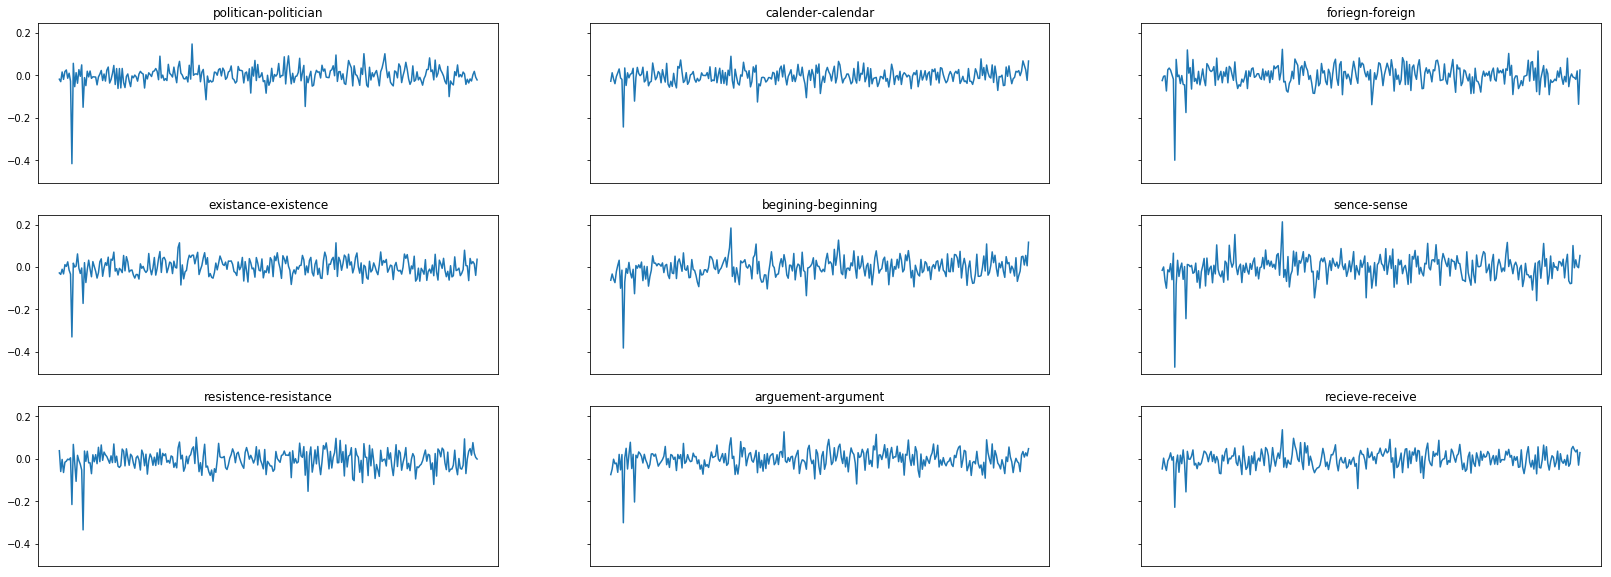

In [43]:
fig, ax = plt.subplots(3, 3, sharey=True)
fig.set_size_inches(28, 10, forward=True)
i = 0
j = 0
for row in samp.itertuples():
    ax[i][j].set_title(row.incorrect + '-' + row.correct)
    ax[i][j].xaxis.set_visible(False)
#     ax[i][j].yaxis.set_visible(False)

    vec = emb[w2id[row.incorrect]]-emb[w2id[row.correct]]
    ax[i][j].plot(vec)
#     ax[i][j].bar(x=list(range(300)), height=vec, color=cmap(np.abs(vec)), width=1)
    i += 1
    if i == 3:
        i = 0
        j += 1

There is a clear pattern with downward spikes in 2 of the early dimensions, and a slightly less clear upward spike about a third of the way along.

In [44]:
# Code for saving the image
# fig.savefig('9x9examples.png', dpi=200)

### Create an initial spelling correction transformation vector 

Our approach is a simple one: We will just take the average difference between correctly and incorrectly spelled word vectors. 
We aren't training a model in statistical learning sense, but we should still split our source data into train and test sets since we want to understand whether the transformation vector is generalluy applicable, i.e. invariant to which word it is used on.

In [45]:
train, test = train_test_split(mistakes, train_size=0.85, random_state=2018)
spell_transform = np.zeros((300,))
for row in train.itertuples():
    spell_transform += emb[w2id[row.incorrect]] - emb[w2id[row.correct]]
spell_transform /= len(train)

/home/ed/anaconda3/envs/tflsrc3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Now we can see what the transformation vector looks like:

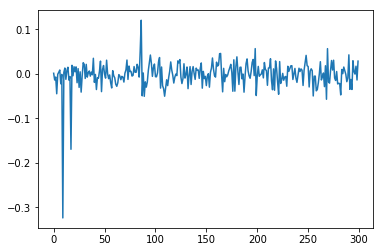

In [46]:
plt.plot(spell_transform)

And we can test how well it performs against the test dataset.

In [47]:
print(len(test))

17


In [48]:
# See how the transformation performs on the test set
test.loc[:, 'fixed'] = toWords(getNeighbours(test.incorrect, transform_vector=spell_transform, c=1), n=1)
print('{} correct out of {}'.format((test.fixed==test.correct).sum(), len(test)))
print('Accuracy on test set: {:.2f}%'.format((test.fixed==test.correct).sum()/len(test)*100))

9 correct out of 17
Accuracy on test set: 52.94%


/home/ed/anaconda3/envs/tflsrc3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ed/anaconda3/envs/tflsrc3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Not great, but perhaps we just need to push the words further in the direction of the correct spellings? 

In [49]:
# See how the transformation performs on the test set
test.loc[:, 'fixed'] = toWords(getNeighbours(test.incorrect, transform_vector=spell_transform, c=1.5), n=1)
print('{} correct out of {}'.format((test.fixed==test.correct).sum(), len(test)))
print('Accuracy on test set: {:.2f}%'.format((test.fixed==test.correct).sum()/len(test)*100))

15 correct out of 17
Accuracy on test set: 88.24%


/home/ed/anaconda3/envs/tflsrc3/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Much better! Let's look at the ones we got wrong:

In [50]:
test[test.fixed!=test.correct]

,correct,incorrect,fixed
32,Fahrenheit,Farenheit,Farenheit
74,pharaoh,pharoah,pharoah


I don't think I would stand much chance of spelling either of those correctly. Perhaps they are spelled wrong so often that they don't follow the same pattern as other spelling mistakes and typos? The plot below lends some support to that idea:

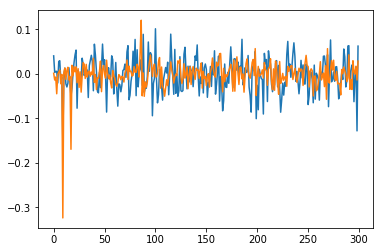

In [51]:
# plt.plot(emb[w2id['Farenheit']]-emb[w2id['Fahrenheit']])
plt.plot(emb[w2id['pharoah']]-emb[w2id['pharaoh']])
plt.plot(spell_transform)

## Build a bigger training set 

Our approach is going to be:
1. Use the initial spell_transform vector to convert a list of correctly spelled word into an incorrectly spelled words by applying it in the opposite direction
2. Since this process is likely to generate lots of noise such as misspelled related words, plurals of the same word, etc we need a way to identify likely misspelling cadidates. To do this we use the jellyfish library to calculate the Levenshtein distance between a misspelling candidate and the correctly spelled world. We also use a few simple heuristic rules. It doesn't need to be perfect, just good enough to filter out the most unlikely candidates.
3. Rebuild the spelling transformation vector using all the new correct: incorrect spelling pairs.

In [52]:
mistakes['lev_score'] = mistakes.apply(lambda x: jellyfish.levenshtein_distance(x.correct, x.incorrect) / max(len(x.correct), len(x.incorrect)), axis=1)
mistakes['lev_distance'] = mistakes.apply(lambda x: jellyfish.levenshtein_distance(x.correct, x.incorrect), axis=1)
mistakes.sort_values('lev_distance').tail()

,correct,incorrect,lev_score,lev_distance
26,disappear,dissapear,0.222222,2
75,piece,peice,0.400000,2
74,pharaoh,pharoah,0.285714,2
12,bizarre,bizzare,0.285714,2
0,achieve,acheive,0.285714,2


We have at most 2 edits in this original list of commonly misspelled words, so we will set an assumption that a spelling mistake or typo cannot have an edit distance of more than 2. We also implement a number of other rules and define a function which takes a pair of words, and will return True if it thinks one is potentially a misspelling of the other.  

In [53]:
MAX_EDITS = 2


def is_misspelling(w1, w2, max_edits=MAX_EDITS):
    # We want to focus on the spelling, and not the case of the letters, so we will lower case both words
    w1 = w1.lower()
    w2 = w2.lower()
    # First check that we don't just have a differently cased version of the same word
    if w1 != w2:
        # Next check that we aren't just creating a plural of of a singular word, or vica versa
        if not ((w1[-1] == 's' and w2[-1] != 's') or (w1[-1] != 's' and w2[-1] == 's')):
            # Next check that we haven't just stuck a 2 letter prefix or suffix on the word e.g. 'invent' ==> 'reinvent', 'invented'
            if not (w1[:-2] == w2 or w2[:-2] == w1 or w1[2:] == w2 or w2[2:] == w1):
                # Next, if the word ends in 'e', check we haven't just added a 'd'
                if not ((w1[-1] == 'e' and w2[-1] == 'd') or (w1[-1] == 'd' and w2[-1] == 'e')):
                    # Finally, if we passed all these tests, then calculate the Levenshtein distance
                    dist = jellyfish.levenshtein_distance(w1, w2)
                    return dist <= max_edits

### Building a list of correctly spelled words 

We need to start with a long list of correctly spelled words, and I don't have one of those... We have a very long list of words (from the word vectors), and they are in descending frequency order, so we could just assume that the first 10,000 or so are spelled correctly. 

However, we can also use our initial spelling transformation vector. If we project each word vector onto the spelling transformation vector, i.e. take the dot product, it should give us an indication of how well the word is spelled.    

Let's see if it works:

In [54]:
# Take the dot product of the spell_transform vector with the first 100,000 word vectors, and sort by the resulting 'score'
scores = np.dot(emb[:20000], spell_transform)
sp = np.argsort(scores)
print ('The top 20 "best spelled" words:\n', ';  '.join([id2w[x] for x in sp[:50]]))
print()
print ('The top 20 "worst spelled" words:\n', ';  '.join([id2w[x] for x in sp[-50:]]))

The top 20 "best spelled" words:
 as;  which;  whose;  particularly;  that;  significant;  addition;  described;  noted;  previously;  While;  the;  continues;  suggests;  Although;  such;  referred;  particular;  present;  including;  continued;  whether;  following;  often;  both;  --;  The;  however;  followed;  their;  remains;  among;  latter;  may;  However;  considered;  rather;  perhaps;  's;  known;  recent;  follows;  given;  become;  appears;  several;  also;  ultimately;  As;  likely

The top 20 "worst spelled" words:
 LFS;  Whats;  cuz;  ps3;  FUCK;  Hobbyist;  Lol;  =D;  Hotel_Review;  ur;  vid;  permalinksaveparent;  wasnt;  Logged;  coz;  ?????;  dat;  THANKS;  hes;  ░;  omg;  points1;  theres;  ;D;  !!!!!!;  ppl;  fuckin;  havent;  ▒;  soo;  Fav;  wouldnt;  shes;  aint;  ive;  teh;  goin;  ║;  luv;  ▄;  commentLoad;  pls;  wtf;  ▀;  !!!!!!!;  lmao;  wat;  !!!!!!!!;  plz;  awsome


Mmmm. Perhaps this isn't just measuring how well a word is spelled?

Let's also look at the projection of the spelling transform against the original un-normalised vectors.

In [55]:
emb_nonorm = np.zeros((50000, 300), dtype=np.float32)

for cc, word in enumerate(list(glove.keys())[:50000]):
    emb_nonorm[cc] = glove[word]

scores = np.dot(emb_nonorm[:20000], spell_transform)
sp_nonorm = np.argsort(scores)
print ('The top 20 "best spelled" words:\n', ';  '.join([id2w[x] for x in sp_nonorm[:50]]))
print ('The top 20 "worst spelled" words:\n', ';  '.join([id2w[x] for x in sp_nonorm[-50:]]))

The top 20 "best spelled" words:
 U.S.;  officials;  political;  whose;  States;  significant;  among;  percent;  University;  economic;  increasingly;  efforts;  often;  individuals;  government;  former;  York;  such;  their;  organizations;  particularly;  --;  financial;  Department;  institutions;  students;  State;  President;  described;  American;  began;  federal;  social;  identified;  his;  may;  which;  United;  noted;  leadership;  including;  remains;  Washington;  activities;  presence;  associated;  Wednesday;  individual;  critical;  largely
The top 20 "worst spelled" words:
 havent;  vid;  ;D;  ═;  ▓;  LinkBack;  !!!!!!;  Fav;  THANKS;  FUCK;  LFS;  omg;  EVINRUDE;  ur;  Airbags;  :{;  hes;  ppl;  ps3;  points3;  Mercruiser;  aint;  dat;  fuckin;  goin;  ive;  MouseWait;  soo;  ░;  shes;  points1;  teh;  !!!!!!!;  wtf;  luv;  pls;  lmao;  ▒;  pmPosts;  !!!!!!!!;  ▄;  wat;  ▀;  ║;  agosorry;  fromServlet;  plz;  awsome;  Hotel_Review;  commentLoad


We can look at the distribution of these scores, but there's no clear breakpoint between correctly spelled and incorrectly spelled (NB correct spellings are to the left hand side, i.e. they get low scores):

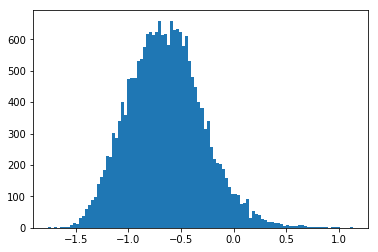

In [56]:
_ = plt.hist(scores, bins=100)

We don't really need all, or even a large proportion of the words. So, let's just pick the top few thousand "best spelled" words from our list sorted by score. Let's look at a few around the 10,000 mark in this list:

In [57]:
[id2w[x] for x in sp[10000:10050]]

['poem',
 'discounted',
 'Monterey',
 'Selected',
 'cycling',
 'USC',
 'inspections',
 'Savings',
 'iii',
 'homeland',
 'Activity',
 'viewpoint',
 'Rodgers',
 '1942',
 'airline',
 'charities',
 'defect',
 'Sophie',
 'shoe',
 'Eva',
 'fathers',
 'allowance',
 'commands',
 'Tell',
 'Paso',
 'utter',
 'Woody',
 '91',
 'NATO',
 'Ukrainian',
 'acid',
 'traded',
 'Patent',
 'Starbucks',
 '9th',
 'irregular',
 'co-workers',
 'Shell',
 '60,000',
 'Nova',
 'Please',
 'mounting',
 'Churches',
 'Put',
 '136',
 'Asset',
 'Workshop',
 'Roundup',
 'Mutual',
 'marijuana']

We've got single letters, hyphenated words, and numbers. Let's restrict attention to lower case words containing at least 3 letters, and only the ascii letters a to z.

We can build a training vocab by searching through the vocabulary sorted according to the spelling score, and filtering by these criteria: 

In [58]:
pattern = re.compile('[\WA-Z0-9_]')

def checkword(wrd, minlen=3):
    # returns True if the wrd only contains the letters a-z
    return len(wrd) >= minlen and pattern.sub('', wrd) == wrd

In [59]:
training_list = [id2w[x] for x in sp[:15000] if checkword(id2w[x])]
len(training_list)

8978

Next, we find the 10 nearest neighbours after applying the spelling transformation in the wrong direction. We then filter these candidate badly spelled words by applying the is_misspelled function we defined above.

In [61]:
%time I = getNeighbours(training_list, spell_transform, -1.5, neighbours=10)

CPU times: user 9min 6s, sys: 3min 12s, total: 12min 18s
Wall time: 3min 16s


In [62]:
# Create pairs
pairs = []
for ls, wrd in zip(I, training_list):
    if wrd in test.correct: # We want to ignore words in our small test set
        continue
    for misspell in ls:
        if checkword(id2w[misspell]) and id2w[misspell] not in training_list and is_misspelling(wrd, id2w[misspell]):
            pairs.append((wrd, id2w[misspell]))
print('Generate {} pairs'.format(len(pairs)))

Generate 14374 pairs


We can check that the process has worked by looking at a few examples:

In [64]:
pairs[1000:1025]

[('leadership', 'leadeship'),
 ('leadership', 'leaderhip'),
 ('leadership', 'leadship'),
 ('reported', 'repoted'),
 ('reported', 'reproted'),
 ('explains', 'explaines'),
 ('explains', 'expains'),
 ('reasons', 'resons'),
 ('commitment', 'committment'),
 ('commitment', 'comitment'),
 ('commitment', 'comittment'),
 ('commitment', 'commitement'),
 ('commitment', 'committement'),
 ('current', 'curent'),
 ('current', 'currrent'),
 ('current', 'currect'),
 ('current', 'curret'),
 ('current', 'curretn'),
 ('current', 'cuurent'),
 ('current', 'currnt'),
 ('purpose', 'pupose'),
 ('purpose', 'prupose'),
 ('purpose', 'perpose'),
 ('purpose', 'purpouse'),
 ('purpose', 'pourpose')]

It looks OK, although a little noisy. The majority of the corruptions appear to have created spelling mistakes, but there are a few where we have just picked a different but correctly spelled word. 

Hopefully averaging across a large sample will iron out the potential biases these examples might introduce.

We can also check by using the dot product scoreing method:

In [45]:
incorrects = [np.dot(emb[w2id[x[1]]], spell_transform) for x in pairs]

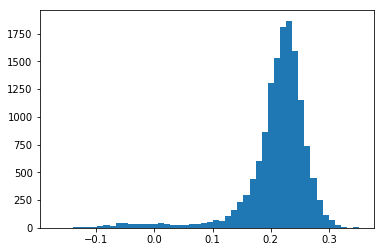

In [46]:
_ =plt.hist(incorrects, bins=50)

Let's look at the examples in that long left hand tail:

In [47]:
[pairs[x] for x in np.argwhere(np.asarray(incorrects) < 0.1)[:, 0]]

[('their', 'thier'),
 ('similar', 'similiar'),
 ('bringing', 'brining'),
 ('will', 'wil'),
 ('successful', 'succesful'),
 ('indicate', 'indicative'),
 ('his', 'hes'),
 ('received', 'recieved'),
 ('demonstrate', 'demonstrable'),
 ('role', 'rôle'),
 ('resulting', 'resultant'),
 ('focuses', 'focusses'),
 ('focused', 'focussed'),
 ('separate', 'seperate'),
 ('emphasis', 'emphases'),
 ('emphasis', 'emphasizes'),
 ('commitment', 'committment'),
 ('financial', 'ﬁnancial'),
 ('across', 'accross'),
 ('existence', 'existance'),
 ('social', 'socio'),
 ('activities', 'activites'),
 ('characterized', 'characterised'),
 ('practices', 'practises'),
 ('initiated', 'instigated'),
 ('receive', 'recieve'),
 ('reflected', 'refracted'),
 ('conclusion', 'conclusive'),
 ('prepared', 'prepped'),
 ('kind', 'kinda'),
 ('committed', 'commited'),
 ('independent', 'independant'),
 ('focusing', 'focussing'),
 ('employees', 'employes'),
 ('carrying', 'ferrying'),
 ('official', 'offical'),
 ('them', 'thier'),
 ('sort

There are a few mispellings, but they mostly look like false examples caused by the data creation process - the 'incorrect' word is just a different word.  Let's remove all of these before creating the new spell transformation vector.  We will be throwing out some of the good ith the bad, but there's plenty left over.

In [48]:
pairs = [pairs[x] for x in np.argwhere(np.asarray(incorrects) > 0.1)[:, 0]]

In [49]:
print(len(pairs))

13734


In [50]:
# Create version 2 of our spelling transformation vector
spell_transform_2 = np.zeros(300)
for p in pairs:
    spell_transform_2 += emb[w2id[p[1]]] - emb[w2id[p[0]]]
spell_transform_2 /= len(pairs)

In [51]:
np.corrcoef(spell_transform, spell_transform_2)

array([[1.        , 0.90623891],
       [0.90623891, 1.        ]])

In [52]:
np.std(spell_transform)

0.030550461498714564

In [53]:
np.std(spell_transform_2)

0.044861174564846666

Compared to the old spell transform vector we have larger spikes in the early dimensions, and most of the remainder are a bit closer to zero.

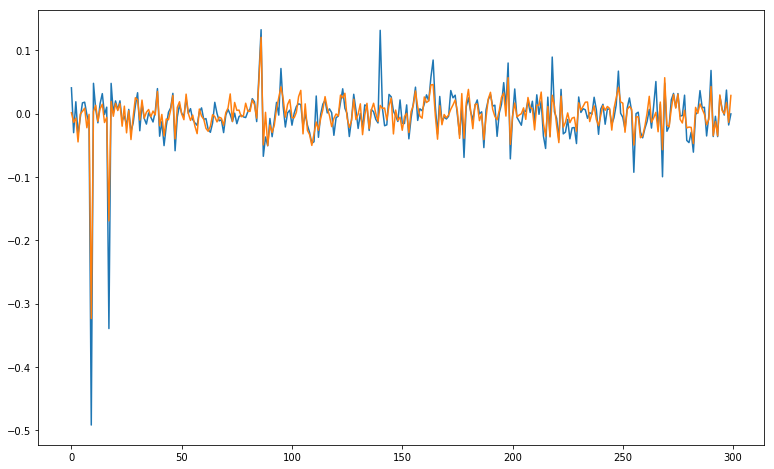

In [54]:
plt.figure(figsize=(13,8))
plt.plot(spell_transform_2)
plt.plot(spell_transform)
# plt.bar(np.arange(300),spell_transform_2, color='b', alpha=0.8)
# plt.bar(np.arange(300),spell_transform, color='r')

# plt.barh(np.arange(300)[::-1], spell_transform_2, height=1)
# plt.barh(np.arange(300)[::-1], spell_transform, height=0.5)

In [55]:
fig.savefig('comparison.png', dpi=200)

Now we can see how well it performs on the help out test set:

In [56]:
test.loc[:, 'fixed'] = toWords(getNeighbours(test.incorrect, transform_vector=spell_transform_2, c=1.4), n=1)
print('Accuracy on test set: {:.2f}%'.format((test.fixed==test.correct).sum()/len(test)*100))

Accuracy on test set: 100.00%


/home/ed/anaconda3/envs/tflsrc3/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


We have fixed the last two problematic spellings. Let's see how it does on the full training set. 

In [57]:
train_pairs = pd.DataFrame(pairs, columns=['correct', 'incorrect'])

In [58]:
print(len(train_pairs))

13734


In [59]:
# See how the transformation performs on the test set
train_pairs.loc[:, 'fixed'] = toWords(getNeighbours(train_pairs.incorrect, transform_vector=spell_transform_2, c=1.4), n=1)
print('Accuracy on train set: {:.2f}%'.format((train_pairs.fixed==train_pairs.correct).sum()/len(train_pairs)*100))

Accuracy on train set: 89.53%


Pretty good - 89% on 14,000 mispelled words. Let's see what we got wrong:

In [60]:
train_pairs[train_pairs.fixed!=train_pairs.correct].sample(20)

,correct,incorrect,fixed
11012,excerpt,excert,brief
13170,ringing,dinging,while
9679,daughter,duaghter,mother
6209,heart,hert,that
10307,loose,losen,loosen
375,carried,carring,carrying
192,three,thre,one
5924,months,monthes,weeks
702,own,onw,one
6994,filling,fillin,fill


An interesting mix. In quite a few cases it looks like we have just picked a completely different word, but in others I think the model has picked a better suggestion than the training data.
Let's look again at the training data 'spelling scores'. We can compare the distribution of correctly answered with incorrectly answered:

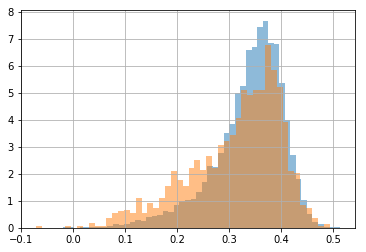

In [61]:
train_pairs['score'] = train_pairs.incorrect.apply(lambda x: np.dot(emb[w2id[x]], spell_transform_2))
train_pairs[train_pairs.fixed==train_pairs.correct].score.hist(bins=50, normed=True, alpha=0.5)
train_pairs[train_pairs.fixed!=train_pairs.correct].score.hist(bins=50, normed=True, alpha=0.5)

The orange distribution represents the incorrect answers. Our predictions appear to be wrong slightly more often for words with a low spell score (i.e. things that are probably spelled correctly). 

Let's look at the incorrect examples that are more like to be misspellings:

In [62]:
train_pairs[(train_pairs.score < 0.15) & (train_pairs.fixed!=train_pairs.correct)].sort_values('score')

,correct,incorrect,fixed,score
3643,ever,ive,'ve,-0.072502
5686,gone,goin,going,-0.005711
13507,mad,lmao,lol,0.009729
4842,saying,sayin,say,0.030316
13001,thank,thanx,thanks,0.038150
5662,real,realy,really,0.038910
3651,belief,belive,believe,0.049055
11375,pack,pak,pak,0.057846
2846,little,alittle,bit,0.063089
3398,leaves,leafs,leafs,0.070282


In [63]:
print(toWords(getNeighbours(['absolutly'], transform_vector=spell_transform_2, c=1.4), n=5))
print(toWords(getNeighbours(['dreampt'], transform_vector=spell_transform_2, c=1.4), n=5))

[['absolutely', 'totally', 'truly', 'really', 'so']]
[['realized', 'dreamed', 'been', 'had', 'meant']]


There are 2 things we could try to improve the results:
1. check that our suggested spelling looks like the original word
2. adjusting the multiplier to take account of how badly misspelled we think the word is. i.e. perhaps for 'bigger' mispellings we need to make more of an adjustment to drag the vector into the correctly spelled zone?

In [64]:
# Define a function to pick the best option from a list of alternatives
def pickBest(candidates_list, word_list):
    best = []
    for candidates, word in zip(candidates_list, word_list):
        found = False
        for c in candidates:
            if c == word or is_misspelling(c, word):
                best.append(c)
                found=True
                break
        if not found:
            # no good candidates found, so just add the original word
            best.append(word)
    return best

In [65]:
# Define a multiplier based on each individual word score
train_pairs['c'] = train_pairs.score.apply(lambda x: 1.2 + x * 1)

In [66]:
train_pairs.loc[:, 'fixed'] = pickBest(toWords(getNeighbours(train_pairs.incorrect, transform_vector=spell_transform_2, c=np.expand_dims(train_pairs['c'].values, 1)), n=5), train_pairs.incorrect)
print('Accuracy on train set: {:.2f}%'.format((train_pairs.fixed==train_pairs.correct).sum()/len(train_pairs)*100))

Accuracy on train set: 91.68%


Better again. As a final step we can try optimising the multiplier parameters.

It takes a while to run each iteration, so we will test against a 10% sample.

In [67]:
from scipy.optimize import fmin

In [68]:
train_sample = train_pairs.sample(frac=0.1, random_state=1234)

In [69]:
# Helper function to run test on the sample for given paramters and return the error rate
def getErrorRate(params):
    train_sample['c'] = train_sample.score.apply(lambda x: params[0]+ x * params[1])
    train_sample.loc[:, 'fixed'] = pickBest(toWords(getNeighbours(train_sample.incorrect, transform_vector=spell_transform_2, c=np.expand_dims(train_sample['c'].values, 1)), n=5), train_sample.incorrect)
    print('Accuracy using params {} and {}: {:.2f}%'.format(params[0], params[1], (train_sample.fixed==train_sample.correct).sum()/len(train_sample)*100))
    return (train_sample.fixed!=train_sample.correct).sum()/len(train_sample)

In [70]:
params = fmin(getErrorRate, [1.2, 1.0],  xtol=0.01)

Accuracy using params 1.2 and 1.0: 90.60%
Accuracy using params 1.26 and 1.0: 89.08%
Accuracy using params 1.2 and 1.05: 90.24%
Accuracy using params 1.14 and 1.0499999999999998: 91.55%
Accuracy using params 1.0799999999999996 and 1.0749999999999997: 91.19%
Accuracy using params 1.14 and 0.9999999999999998: 91.62%
Accuracy using params 1.1099999999999999 and 0.9749999999999996: 91.41%
Accuracy using params 1.0799999999999998 and 1.0499999999999998: 91.19%
Accuracy using params 1.1099999999999999 and 1.0374999999999999: 91.48%
Accuracy using params 1.17 and 1.0125: 91.26%
Accuracy using params 1.125 and 1.03125: 91.70%
Accuracy using params 1.1249999999999998 and 0.9812500000000002: 91.48%
Accuracy using params 1.13625 and 1.0328125: 91.62%
Accuracy using params 1.1287499999999997 and 0.9984375000000001: 91.70%
Accuracy using params 1.1137499999999998 and 1.0296875000000003: 91.55%
Accuracy using params 1.1334374999999999 and 1.007421875: 91.70%
Accuracy using params 1.1203124999999998 

We can now try the best performing paramters with the full dataset:

In [71]:
train_pairs['c'] = train_pairs.score.apply(lambda x: params[0] + x * params[1])
train_pairs.loc[:, 'fixed'] = pickBest(toWords(getNeighbours(train_pairs.incorrect, transform_vector=spell_transform_2, c=np.expand_dims(train_pairs['c'].values, 1)), n=5), train_pairs.incorrect)
print('Accuracy on train set: {:.2f}%'.format((train_pairs.fixed==train_pairs.correct).sum()/len(train_pairs)*100))

Accuracy on train set: 92.60%


Better again. Let's take a final look at what we are still getting wrong:

In [73]:
train_pairs[train_pairs.fixed!=train_pairs.correct].sample(20)

,correct,incorrect,fixed,score,c
3958,capacity,capabilty,capability,0.411489,1.549348
10499,allocated,alloted,allotted,0.163383,1.293489
11393,shake,shakin,shakin,0.167715,1.297956
12953,fitted,kitted,kitted,0.134104,1.263295
776,either,niether,neither,0.301731,1.436160
2025,absent,absense,absence,0.198203,1.329397
3069,enable,beable,beable,0.269582,1.403007
3643,ever,ive,ive,-0.072502,1.050233
5092,attack,attact,attract,0.349642,1.485568
10325,watch,wath,what,0.335083,1.470554


There are still some cases when we are not finding the right spelling, but most of the examples now seem to be errors in the training set. 

## Building a spell correcting dictionary 

There's no point correcting words that are not real words. For example, punctuation, urls, file names, etc. So, we will try to filter the original list before processing. 

In [124]:
allwords = [x for x in id2w if checkword(x, 3)]

In [125]:
print(len(allwords))

418757


In [126]:
allwords[-25:]

['theaflavin',
 'theproducts',
 'thumbcuffs',
 'todmorden',
 'topl',
 'trainiing',
 'trompettes',
 'tylerdurden',
 'unaturally',
 'uniao',
 'upstretched',
 'vakker',
 'vampaneze',
 'vinted',
 'vocÃª',
 'wiid',
 'woombie',
 'wordsforyoungmen',
 'wried',
 'wwent',
 'xalisae',
 'xtremecaffeine',
 'yildirim',
 'zipout',
 'zulchzulu']

In [77]:
allwords = pd.DataFrame(allwords, columns=['original'])
allwords['score'] = allwords.original.apply(lambda x: np.dot(emb[w2id[x]], spell_transform))
allwords['c'] = allwords.score.apply(lambda x: params[0]+ x * params[1])

In [81]:
# NB this takes a long time. I'm running faiss on CPU and it took about 45 minutes.
# Don't bother trying to run it with the scipy cdist function
allwords['fixed'] = pickBest(toWords(getNeighbours(allwords.original, transform_vector=spell_transform_2, c=np.expand_dims(allwords['c'].values, 1)), n=5), allwords.original) 

How many words have we changed?

In [101]:
print(sum(allwords.fixed!=allwords.original))

37581


Not that many. Let's look at a sample of the corrections:

In [100]:
allwords[allwords.fixed!=allwords.original].sample(50)

,original,score,c,fixed
260756,lasty,0.232130,1.364384,last
161306,yto,0.219827,1.351697,to
88882,ablum,0.238479,1.370932,album
293618,mster,0.211182,1.342781,master
351266,libility,0.213370,1.345037,liability
133519,particpated,0.210965,1.342558,participated
295432,destroing,0.269723,1.403152,destroying
364046,dmall,0.174538,1.304992,small
112064,mosiac,0.186702,1.317536,mosaic
289029,riginally,0.171273,1.301626,originally


These look good. What about the some of the ones we didn't correct:

In [111]:
allwords[allwords.fixed==allwords.original].sample(50).sort_values('score', ascending=False)

,original,score,c,fixed
246391,koktel,0.236641,1.369036,koktel
227529,villainize,0.221062,1.352970,villainize
336553,powerstone,0.213821,1.345503,powerstone
220864,oddscasinos,0.201709,1.333012,oddscasinos
220789,tennage,0.191337,1.322317,tennage
388165,abouttheir,0.191151,1.322124,abouttheir
171695,bikepath,0.188989,1.319895,bikepath
278541,compresa,0.181337,1.312004,compresa
360206,royersford,0.178726,1.309311,royersford
288780,titilate,0.178356,1.308930,titilate


Taking just one example from this list - 'tennage'. This looks like an obvious candidate for correction, so why hasn't our method worked?

In [120]:
print(toWords(getNeighbours(['tennage'], transform_vector=spell_transform_2, c=1.32), n=5))
print(toWords(getNeighbours(['tennage'], transform_vector=spell_transform_2, c=1.4), n=5))

[['tennage', 'teenage', 'young', 'girls', 'boys']]
[['teenage', 'tennage', 'young', 'girls', 'individual']]


It look like the parameters need further tweaking to get to the correct answer.

However, a number of the other mistakes are joined words, e.g. 'abouttheir'. This method can't help us with these examples since it can only ever map to a single word.

Finally, let's save the mapping as both a python dictionary, and as a csv file.

In [122]:
import pickle
# Save the distionary both as a pickle object and as a csv file
spellingDict = {k:v for _, k,v in allwords.loc[allwords.fixed!=allwords.original, ['original', 'fixed']].itertuples()}
pickle.dump(spellingDict, open('spellingDict.pkl', 'wb'))
allwords.loc[allwords.fixed!=allwords.original, ['original', 'fixed']].to_csv('spelling_pairs.csv.gz', index=False, compression='gzip')